In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd
from IPython.display import Audio
import librosa
from librosa import display
import librosa.display
from iteration_utilities import deepflatten #flatten nested lists
from fractions import Fraction
import pretty_midi
import fluidsynth
#import soundfile as sf
from music21 import chord, corpus, environment, meter, midi, note, stream, tempo
import itertools
import random
import mchmm #for Markov models

#conda install -c conda-forge sox
import pysndfx #sound processing
import nltk #for NLP

Install MuseScore

# Intro to Music21

Full documentation: http://web.mit.edu/music21/

# Configure Music21

The library uses your installation of MuseScore to display scores. Tell it where the MuseScore executable can be found on your computer

In [2]:
# Linux path
#musescore_executable = '/usr/bin/mscore'
# Windows path (adapt Program Files)
#musescore_executable = r'C:\Program Files (x86)\MuseScore 3\bin\MuseScore3.exe'
# Mac path
musescore_executable = '/Applications/MuseScore 3.app/Contents/MacOS/mscore'

environment.set('musescoreDirectPNGPath', musescore_executable)
environment.set('musicxmlPath', musescore_executable)
environment.set('autoDownload', 'allow')

## Data structure

The main musical object we will work with in music21 is note.Note. Each note.Note object, unsurprisingly, represents... one note!

In [3]:
n = note.Note()

There are four main containers (streams) of musical objects in music21: 
- stream.Measure, which is meant to contain a segment of music with no internal subdivision (e.g., no barlines)
- stream.Stream and stream.Part, which are meant to gather several adjacent measures (e.g., an individual instrument in a score) 
- stream.Score, which is meant to gather several simultaneous streams (e.g., the whole score)

The different types of stream can be organised hierarchically: a stream.Stream may contain two simultaneous stream.Parts, each comprising several adjacent stream.Measures. 

For example, let us have a look at this chorale by J. S. Bach, drawn from musci21 corpora:

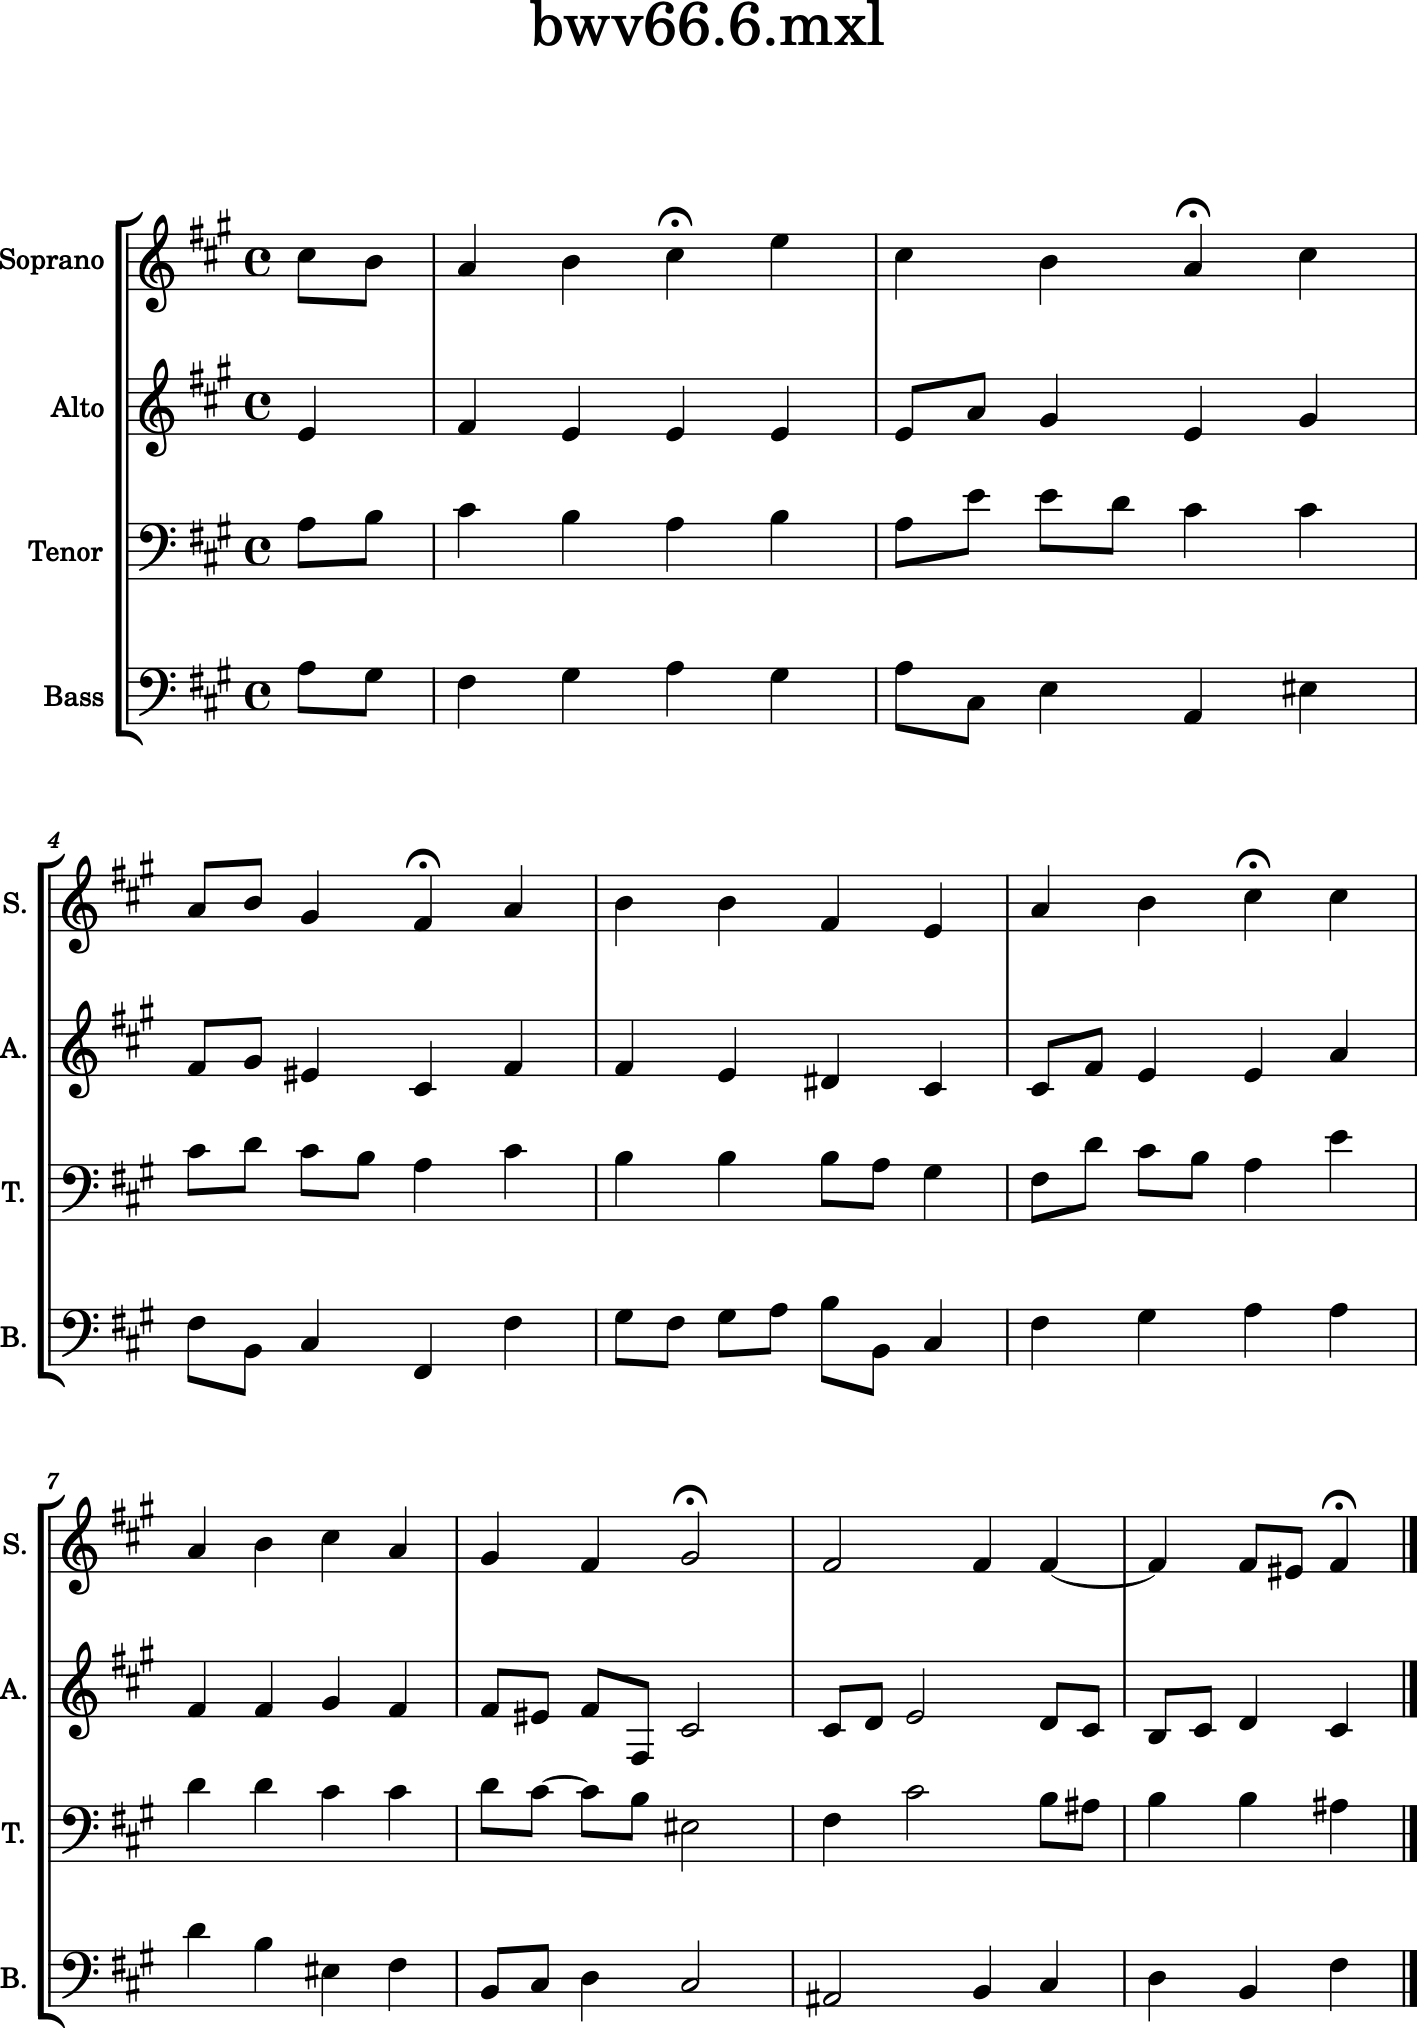

In [4]:
bach_chorale = corpus.parse('bwv66.6')
bach_chorale.show()

The bach_chorale variable now stores a stream.Score object:

In [5]:
bach_chorale

<music21.stream.Score 0x7ffe73391700>

and, if we look into the full data structure, we see how note.Note objects are embedded into stream.Measure objects, which are nested into stream.Part objects (one for Soprano, one for Alto, ecc), which collectively form the stream.Score: 

In [6]:
bach_chorale.show('text')

{0.0} <music21.metadata.Metadata object at 0x7ffe73391640>
{0.0} <music21.stream.Part Soprano>
    {0.0} <music21.instrument.Instrument 'P1: Soprano: Instrument 1'>
    {0.0} <music21.stream.Measure 0 offset=0.0>
        {0.0} <music21.clef.TrebleClef>
        {0.0} <music21.key.Key of f# minor>
        {0.0} <music21.meter.TimeSignature 4/4>
        {0.0} <music21.note.Note C#>
        {0.5} <music21.note.Note B>
    {1.0} <music21.stream.Measure 1 offset=1.0>
        {0.0} <music21.note.Note A>
        {1.0} <music21.note.Note B>
        {2.0} <music21.note.Note C#>
        {3.0} <music21.note.Note E>
    {5.0} <music21.stream.Measure 2 offset=5.0>
        {0.0} <music21.note.Note C#>
        {1.0} <music21.note.Note B>
        {2.0} <music21.note.Note A>
        {3.0} <music21.note.Note C#>
    {9.0} <music21.stream.Measure 3 offset=9.0>
        {0.0} <music21.layout.SystemLayout>
        {0.0} <music21.note.Note A>
        {0.5} <music21.note.Note B>
        {1.0} <music21.note.Not

Stream objects behave as iterators over their content:

In [7]:
[x for x in bach_chorale]

 <music21.stream.Part Soprano>,
 <music21.stream.Part Alto>,
 <music21.stream.Part Tenor>,
 <music21.stream.Part Bass>,
 <music21.layout.StaffGroup <music21.stream.Part Soprano><music21.stream.Part Alto><music21.stream.Part Tenor><music21.stream.Part Bass>>]

We can flatten the hierarchy of the data structure, gathering all objects that are not containers of other objects in a single list:

In [8]:
[x for x in bach_chorale.flat]

 <music21.instrument.Instrument 'P1: Soprano: Instrument 1'>,
 <music21.instrument.Instrument 'P2: Alto: Instrument 2'>,
 <music21.instrument.Instrument 'P3: Tenor: Instrument 3'>,
 <music21.instrument.Instrument 'P4: Bass: Instrument 4'>,
 <music21.clef.TrebleClef>,
 <music21.clef.TrebleClef>,
 <music21.clef.BassClef>,
 <music21.clef.BassClef>,
 <music21.key.Key of f# minor>,
 <music21.key.Key of f# minor>,
 <music21.key.Key of f# minor>,
 <music21.key.Key of f# minor>,
 <music21.meter.TimeSignature 4/4>,
 <music21.meter.TimeSignature 4/4>,
 <music21.meter.TimeSignature 4/4>,
 <music21.meter.TimeSignature 4/4>,
 <music21.note.Note C#>,
 <music21.note.Note E>,
 <music21.note.Note A>,
 <music21.note.Note A>,
 <music21.layout.StaffGroup <music21.stream.Part Soprano><music21.stream.Part Alto><music21.stream.Part Tenor><music21.stream.Part Bass>>,
 <music21.note.Note B>,
 <music21.note.Note B>,
 <music21.note.Note G#>,
 <music21.note.Note A>,
 <music21.note.Note F#>,
 <music21.note.Note C#

We can also selectively pick the note objects:

In [9]:
[[note for note in voice.flat.notes] for voice in bach_chorale.parts]

[[<music21.note.Note C#>,
  <music21.note.Note B>,
  <music21.note.Note A>,
  <music21.note.Note B>,
  <music21.note.Note C#>,
  <music21.note.Note E>,
  <music21.note.Note C#>,
  <music21.note.Note B>,
  <music21.note.Note A>,
  <music21.note.Note C#>,
  <music21.note.Note A>,
  <music21.note.Note B>,
  <music21.note.Note G#>,
  <music21.note.Note F#>,
  <music21.note.Note A>,
  <music21.note.Note B>,
  <music21.note.Note B>,
  <music21.note.Note F#>,
  <music21.note.Note E>,
  <music21.note.Note A>,
  <music21.note.Note B>,
  <music21.note.Note C#>,
  <music21.note.Note C#>,
  <music21.note.Note A>,
  <music21.note.Note B>,
  <music21.note.Note C#>,
  <music21.note.Note A>,
  <music21.note.Note G#>,
  <music21.note.Note F#>,
  <music21.note.Note G#>,
  <music21.note.Note F#>,
  <music21.note.Note F#>,
  <music21.note.Note F#>,
  <music21.note.Note F#>,
  <music21.note.Note F#>,
  <music21.note.Note E#>,
  <music21.note.Note F#>],
 [<music21.note.Note E>,
  <music21.note.Note F#>,
  <

## Playback

In order to play the sound of note objects, let us embed them into a stream object:

In [10]:
m = stream.Measure() #create stream.Measure
m.append(n) #embed note in Measure

and then

In [11]:
def play(score):
    #Shortcut to play a stream
    midi.realtime.StreamPlayer(score).play()

In [12]:
play(m)

pygame 2.0.1 (SDL 2.0.14, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


Each note has two main attributes: its pitch and its duration. 

By default, the pitch of note.Note is a "middle C", i.e., the C in the middle octave of a piano keyboard. Its duration, by default, is a quarter-note.

We can see it in score representation:

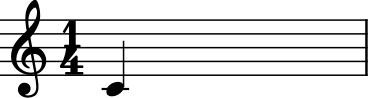

In [13]:
note.Note().show()

Clearly, it is possible to manipulate both the pitch and the duration of a note.Note object.

## Pitch

There are several ways to represent and refer to the pitch of a note.

#### Pitch class and octave
Western musicians typically refer to the twelve chromatic pitches by their name: C, C#\Db, D, D#\Eb, ...

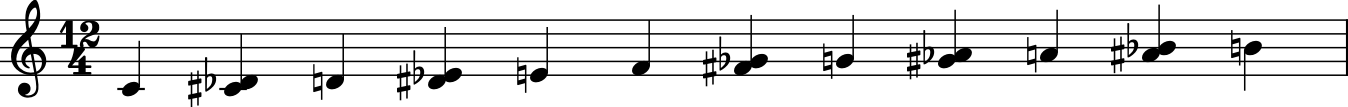

In [14]:
notes = [['C'], ['C#', 'Db'], ['D'], ['D#', 'Eb'], ['E'], ['F'], ['F#', 'Gb'], ['G'], ['G#','Ab'], ['A'], ['A#','Bb'], ['B']]
m = stream.Measure()
m.append([chord.Chord([note.Note(name) for name in pitch_class]) for pitch_class in notes])

m.show()

However, note that the name of a note is not sufficient to uniquely identify its pitch. In fact, we have one C, one C#\Db, etc. for each octave.

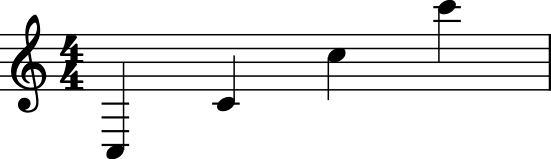

In [15]:
m = stream.Measure()
m.append([note.Note('C'+str(octave)) for octave in range(3,7)])
m.show()

As a consequence, we may identify the pitch of a note by specifying its name (or pitch class) and its octave. For example, the pitch class of the default Note object is

In [16]:
note.Note().pitch.name

'C'

and its octave is

In [17]:
note.Note().pitch.octave

4

Let us now define a new Note object, corresponding to the C# right above the middle C:

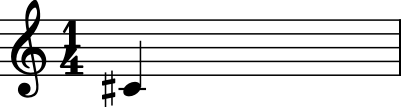

In [18]:
Csharp = note.Note(pitch = 'C#', octave = 4)
Csharp.show()

or

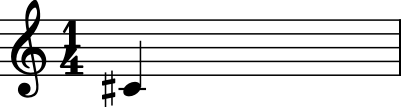

In [19]:
CsharpALT = note.Note(pitch = 'C#4')
CsharpALT.show()

In [20]:
#Are Csharp and CsharpALT the same note?
Csharp == CsharpALT

True

#### MIDI pitch
Alternatively, we may map each key of the piano keyboard onto an integer. This representation, the MIDI pitch, is conventionally defined so that "middle C" has value 60, and all other values are determined accordingly. As a consequence, the default MIDI pitch of a note.Note object is...

In [21]:
note.Note().pitch.midi

60

Let us now create a new note object representing a note with pitch class E, but one octave higher than middle C. Pitch class E is 4 halfsteps above pitch class C (C --> C# --> D --> D# -->E), and we further need to move one octave higher, which is 12 more halfsteps:

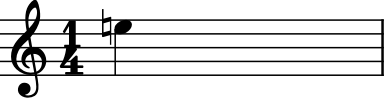

In [22]:
highE = note.Note(pitch = 60 + 4 + 12)
highE.show()

We can listen to both our Csharp and our highE, one after the other:

In [23]:
melodic_interval = stream.Measure()
melodic_interval.append([Csharp, highE])
play(melodic_interval)

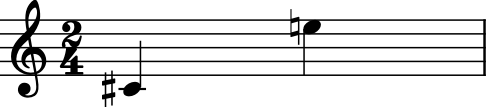

In [24]:
melodic_interval.show()

If we want to hear them simultaneously, we can create a chord object:

In [25]:
c = chord.Chord([Csharp, highE])
harmonic_interval = stream.Measure()
harmonic_interval.append(c)
play(harmonic_interval)

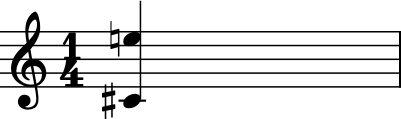

In [26]:
harmonic_interval.show()

#### Absolute frequency

While picking from the chromatic scale is the default for many genres in the Western historical tradition, this is by no means the only option (more on this in Week 4). In particular, we can also specify the pitch of a note by its absolute frequency in Hz:

In [27]:
n1 = note.Note(name = 'A4')

## Create a new note object and reassign its pitch in terms of an absolute frequency
n2 = note.Note()
n2.pitch.frequency = 450 #Hz

## Create a new note object and reassign its pitch in terms of an absolute frequency
n3 = note.Note()
n3.pitch.frequency = 460 #Hz

n4 = note.Note(name = 'A#4')

m = stream.Measure()
m.append([n1, n2, n3, n4])


play(m)

Note that, if you choose arbitrary frequencies that do not match any of the chromatic tones, the score is not an appropriate representation anymore. The score representation is tailored to encode Western (mainly tonal) music, and does not afford appropriate notation for micro-tonal pitches, i.e., pitches that fall in-between the twelve chromatic tones. If you try, you will get an approximation to the closest quarter-tone, which is as far as ordinary Western notation gets. In particular, observe how the last two tones are *notated* as being the same pitch, yet they *sound* different.

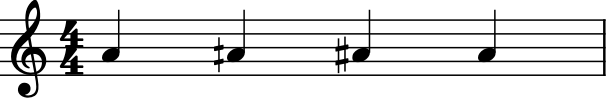

In [28]:
m.show()

#### Microtonal tuning

One way to work with microtonal pitches is to interpret them as deformations of the familiar chromatic pitches. For example, let us look again at J. S. Bach's chorale:

In [29]:
bach_chorale = corpus.parse('bwv66.6')
play(bach_chorale)

We can imagine to play this chorale on a de-tuned keyboard. Specifically, let us de-tune each of the 128 "keys" of the midi-pitched keyboard by a random value comprised betweeen -50 and +50 cents (1 cent is 1/100 of a semitone): 

In [30]:
keyDetune = []
for i in range(127):
    keyDetune.append(random.randint(-50, 50))

Now, we apply the randomly determined mistuning to the original chorale, and play the result:

In [31]:
for n in bach_chorale.flat.notes:
    n.pitch.microtone = keyDetune[n.pitch.midi] #apply the microtonal tuning to each note in the piece
sp = midi.realtime.StreamPlayer(bach_chorale)
sp.play()

However, considering microtonal pitches as deformation of chromatic pitches is just one option. Pitch-space is a continuous interval of positive real numbers, spanning the whole range of audible frequencies (~20Hz - ~20000Hz) and you can and should explore creative ways to filter and organise this space!

## Duration

In music21, durations are expressed relative to a "musical" measurement unit, which is the quarterLength, i.e., the duration of a quarter note. The quarter note is itself 1/4 of a whole note, and other typical duration values in Western notation can be obtained by dividing and multiplying by powers of 2.

From left to right, a 64th note, a 32th note, a 16th note, an eigth note, a quarter note, a half note, a whole note, and a brevis (2 x whole note) 

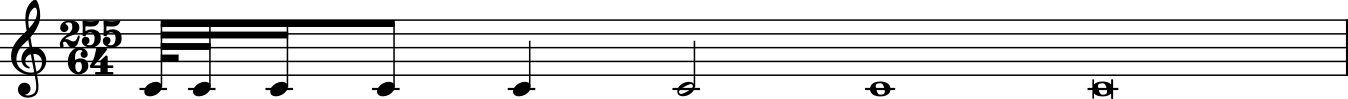

In [32]:
m = stream.Measure()
for i in range(-4, 4):
    m.append(note.Note(quarterLength = 2 ** i))
m.show()    

and the corresponding rests (i.e., silences)

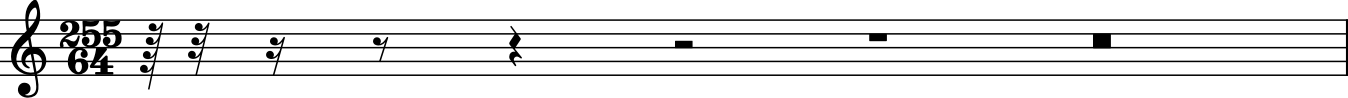

In [33]:
m = stream.Measure()
for i in range(-4, 4):
    m.append(note.Rest(quarterLength = 2 ** i))
m.show()  

It is also possible to have ternary (or n-ary) splits of these basic durations:

In [34]:
s = stream.Stream()

unit = 1 #unit to be split
mUnit = stream.Measure(0)
mUnit.append(note.Note(quarterLength = unit))


N = 3 #N-ary split
mTuplet = stream.Measure(1)
for i in range(N):
    mTuplet.append(note.Note(quarterLength = unit/N))

s.append([mUnit, mTuplet])

play(s)

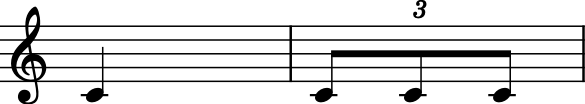

In [35]:
s.show()

In [36]:
mUnit.quarterLength == mTuplet.quarterLength

True

Clearly, it is also possible to assign completely arbitrary durations!

In [37]:
dur = [np.sqrt(5), np.pi, 11/13]

m = stream.Measure()
m.append([note.Note(quarterLength = x) for x in dur])

play(m)

Do not expect to be able to show this measure in score notation! (try, if you dare)

In [38]:
#m.show()

Nevertheless, you can still choose a piano-roll representation:

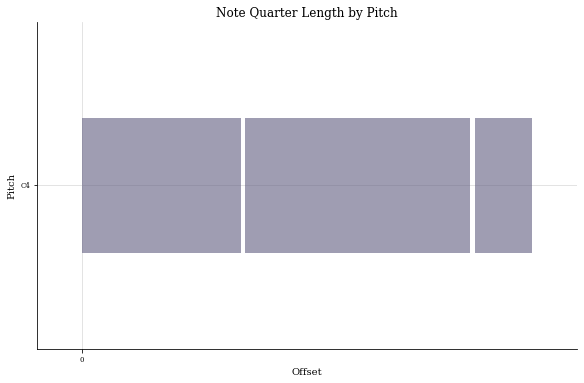

In [39]:
m.plot()

#### Tempo

To set the *actual* duration of a note, we also need to specify the **tempo** (the speed), which is expressed in beats (quarter-notes) per minute (bpm). The default tempo is 120bpm (i.e., two quarter notes per second). At 60bpm, the quarterLength unit corresponds to seconds.

In [40]:
m = stream.Measure()
m.append(tempo.MetronomeMark(number = 60)) #Set the tempo at 60bpm

for i in range(4): #                           
    m.append(note.Note(quarterLength = 1))
    
play(m)

#### Meter

In Western notation the duration of a measure, the meter, is typically specified at the outset. If you set the Time Signature in a stream.Stream() object, measure splits will be added automatically.

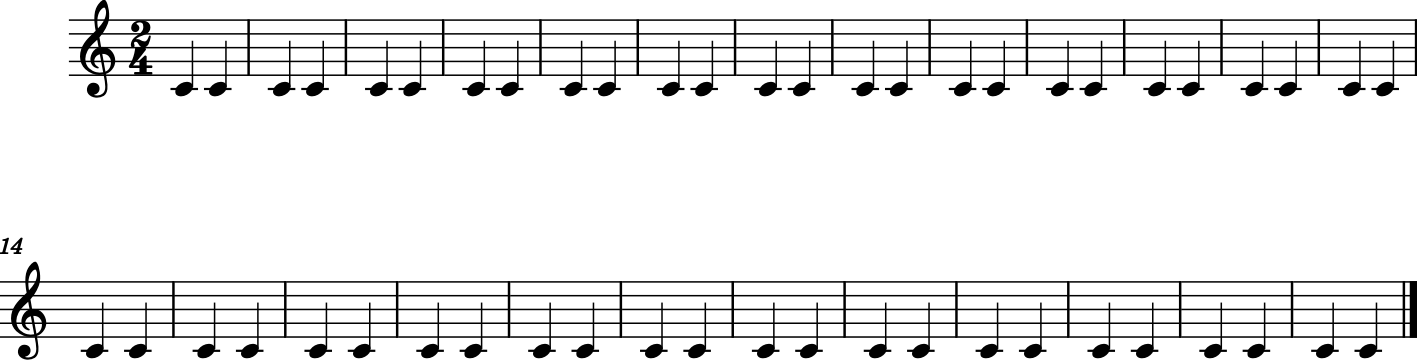

In [41]:
s = stream.Stream()
s.append(meter.TimeSignature('2/4'))

for i in range(50): #                           
    s.append(note.Note(quarterLength = 1))
    
s.show()

Otherwise, you can build a stream object by assembling several measures...

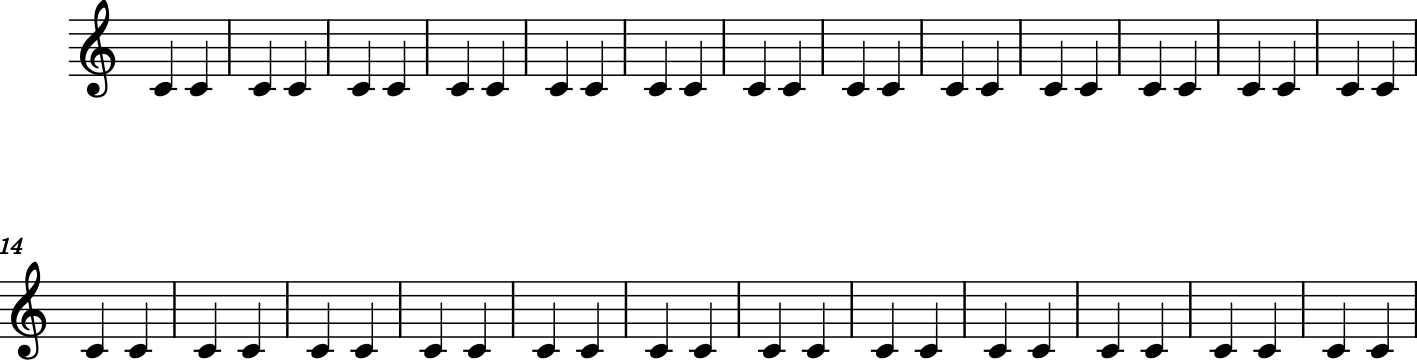

In [42]:
s = stream.Stream()

for i in range(25):
    m = stream.Measure(i)
    m.append([note.Note(), note.Note()])
    s.append(m)
    
s.show()

... not necessarily with the same meter:

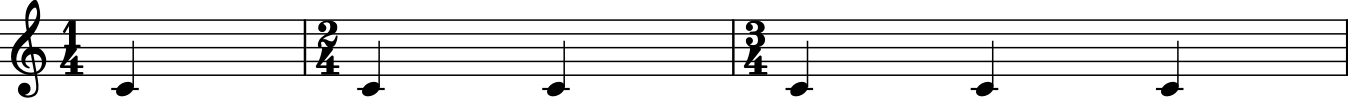

In [43]:
s = stream.Stream()

for i in range(1,4):
    m = stream.Measure(i)
    m.append(meter.TimeSignature(str(i)+'/4'))
    m.append([note.Note() for k in range(i)])
    s.append(m)
    
s.show()

#### Offset

The position of notes in time is quantified in terms of their distance from the beginning of the stream object they belong to, the **offset**. The offset is also measured in quarterLength units. 

Let us look again at the first couple of bars from the chorale:

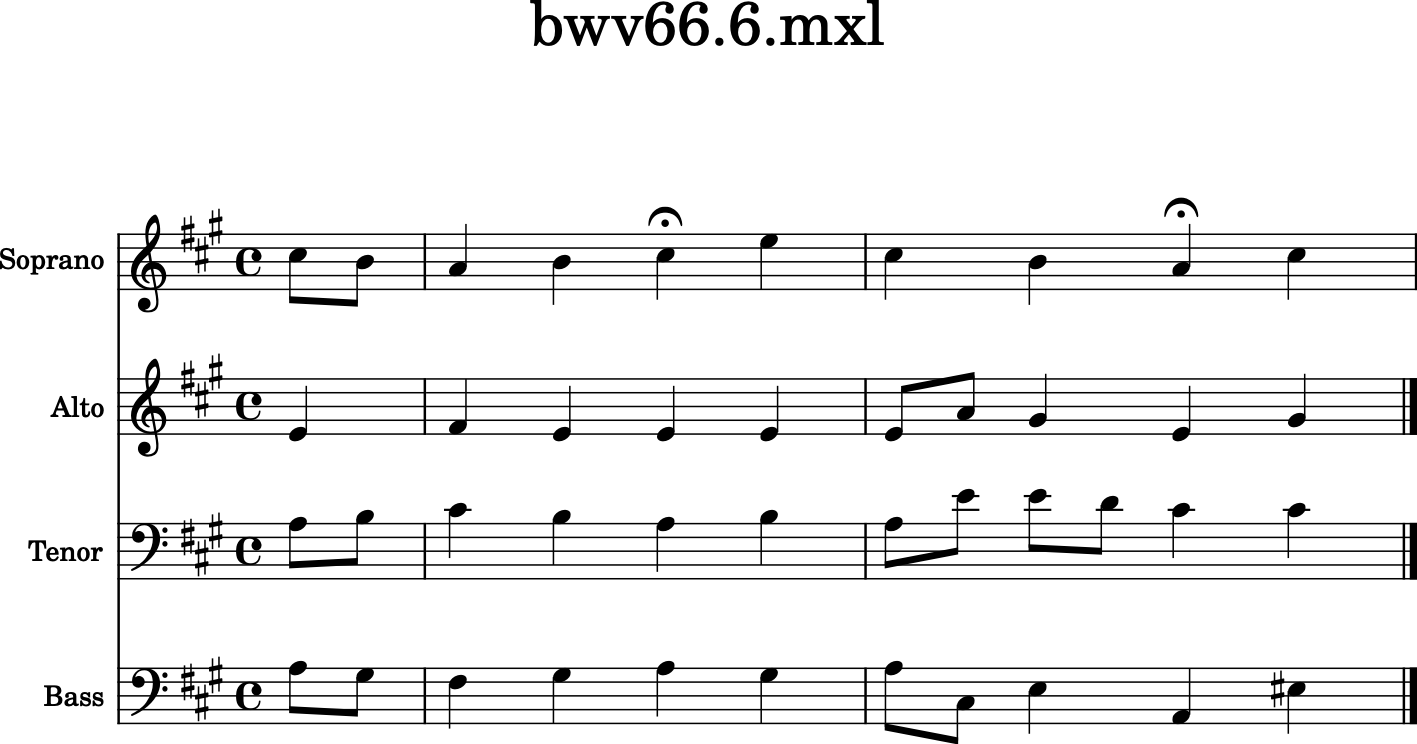

In [44]:
bach_chorale.measures(0, 2).show()

Let's select the second note of the first complete bar in the Soprano part. It starts after two quarter-notes from the beginning of the stream:

In [45]:
list(bach_chorale.parts[0].flat.getElementsByOffset(2, classList = [note.Note])) #the classList argument specifies what type of objects we want to extract. In this case, notes

[<music21.note.Note B>]

Now, let's extract all notes starting at the second eigth-note of the second complete bar (i.e., after 5.5 quarter-notes from the beginning of the stream):

In [46]:
list(bach_chorale.flat.getElementsByOffset(5.5, classList = [note.Note]))

[<music21.note.Note A>, <music21.note.Note E>, <music21.note.Note C#>]

The three eigth-notes in the Alto (A), Tenor (E) and Bass (C#) are the only notes that **start** at offset 5.5. However, note that che C# in the Soprano is also sounding at this moment in time. If we are interested in selecting all notes that are sounding at the given offset, rather than those that start at that offset, we do

In [47]:
list(bach_chorale.flat.getElementsByOffset(5.5, mustBeginInSpan = False,  classList = [note.Note]))

[<music21.note.Note C#>,
 <music21.note.Note A>,
 <music21.note.Note E>,
 <music21.note.Note C#>]

We can use these tools to select specific notes and modify them. Let us change the last C# in the soprano into a D:

In [48]:
bach_chorale.parts[0].flat.getElementsByOffset(8, classList = [note.Note])[0].pitch.name = 'D5'

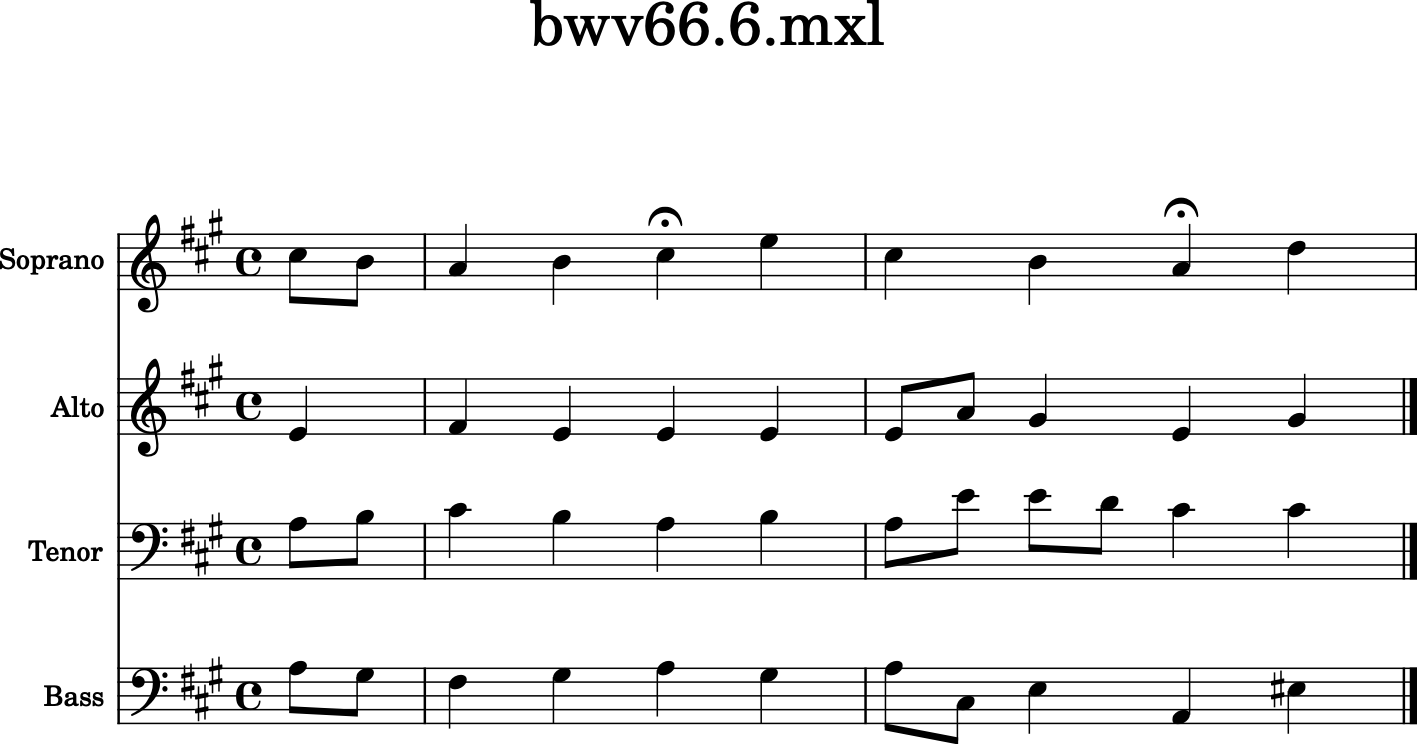

In [49]:
bach_chorale.measures(0, 2).show()

# An example

Pitch material is drawn from J. S. Bach's musical signature (Bb, A, C, B, or BACH in german notation).

Can you figure out what is going on in this "piece"? What could the musical idea be? What determines when the piece ends? Is this really **one** piece?

In [50]:
BACH = ['Bb4', 'A4', 'C5', 'B4']
durations = [1.5, 1, 0.5, 0.5, 0.5] 

n_bars_per_group = 3

bpm = 220
timeSig = '4/4'

s = stream.Stream()
s.append(tempo.MetronomeMark(number = bpm))
s.append(meter.TimeSignature('4/4'))


measure_count = 0 
motto = BACH
while len(set(motto)) > 1 :
    for bar in range(n_bars_per_group):
        m = stream.Measure(measure_count)

        random.shuffle(durations)
    
        selected_notes = [note.Note(pitch = random.choice(motto), quarterLength = dur) for dur in durations]
        m.append(selected_notes)
    
        s.append(m)
        
        measure_count += 1
            
    motto = list(s[-n_bars_per_group:].flat.pitches)

durations = sorted(durations)[1:]
slower = 1.5
while len(durations) >= 1:
    m.append(tempo.MetronomeMark(number = bpm/slower))
    for bar in range(n_bars_per_group):
        
        total_duration = sum(durations)
        if int(total_duration) != total_duration:
            n_beats = str(int(2*total_duration))
            unit = '8'
        else:
            n_beats = str(int(total_duration))
            unit = '4'
            
        m = stream.Measure(measure_count)
        m.append(meter.TimeSignature(n_beats+'/'+unit))

        sample_durations = durations.copy()
        random.shuffle(sample_durations)
        selected_notes = [note.Note(pitch = random.choice(motto), quarterLength = dur) for dur in sample_durations]
        m.append(selected_notes)
    
        s.append(m)
        
        measure_count += 1
    
    durations = durations[1:]
    slower += 0.5

Here is the output in three different representations: score, audio, and piano roll.

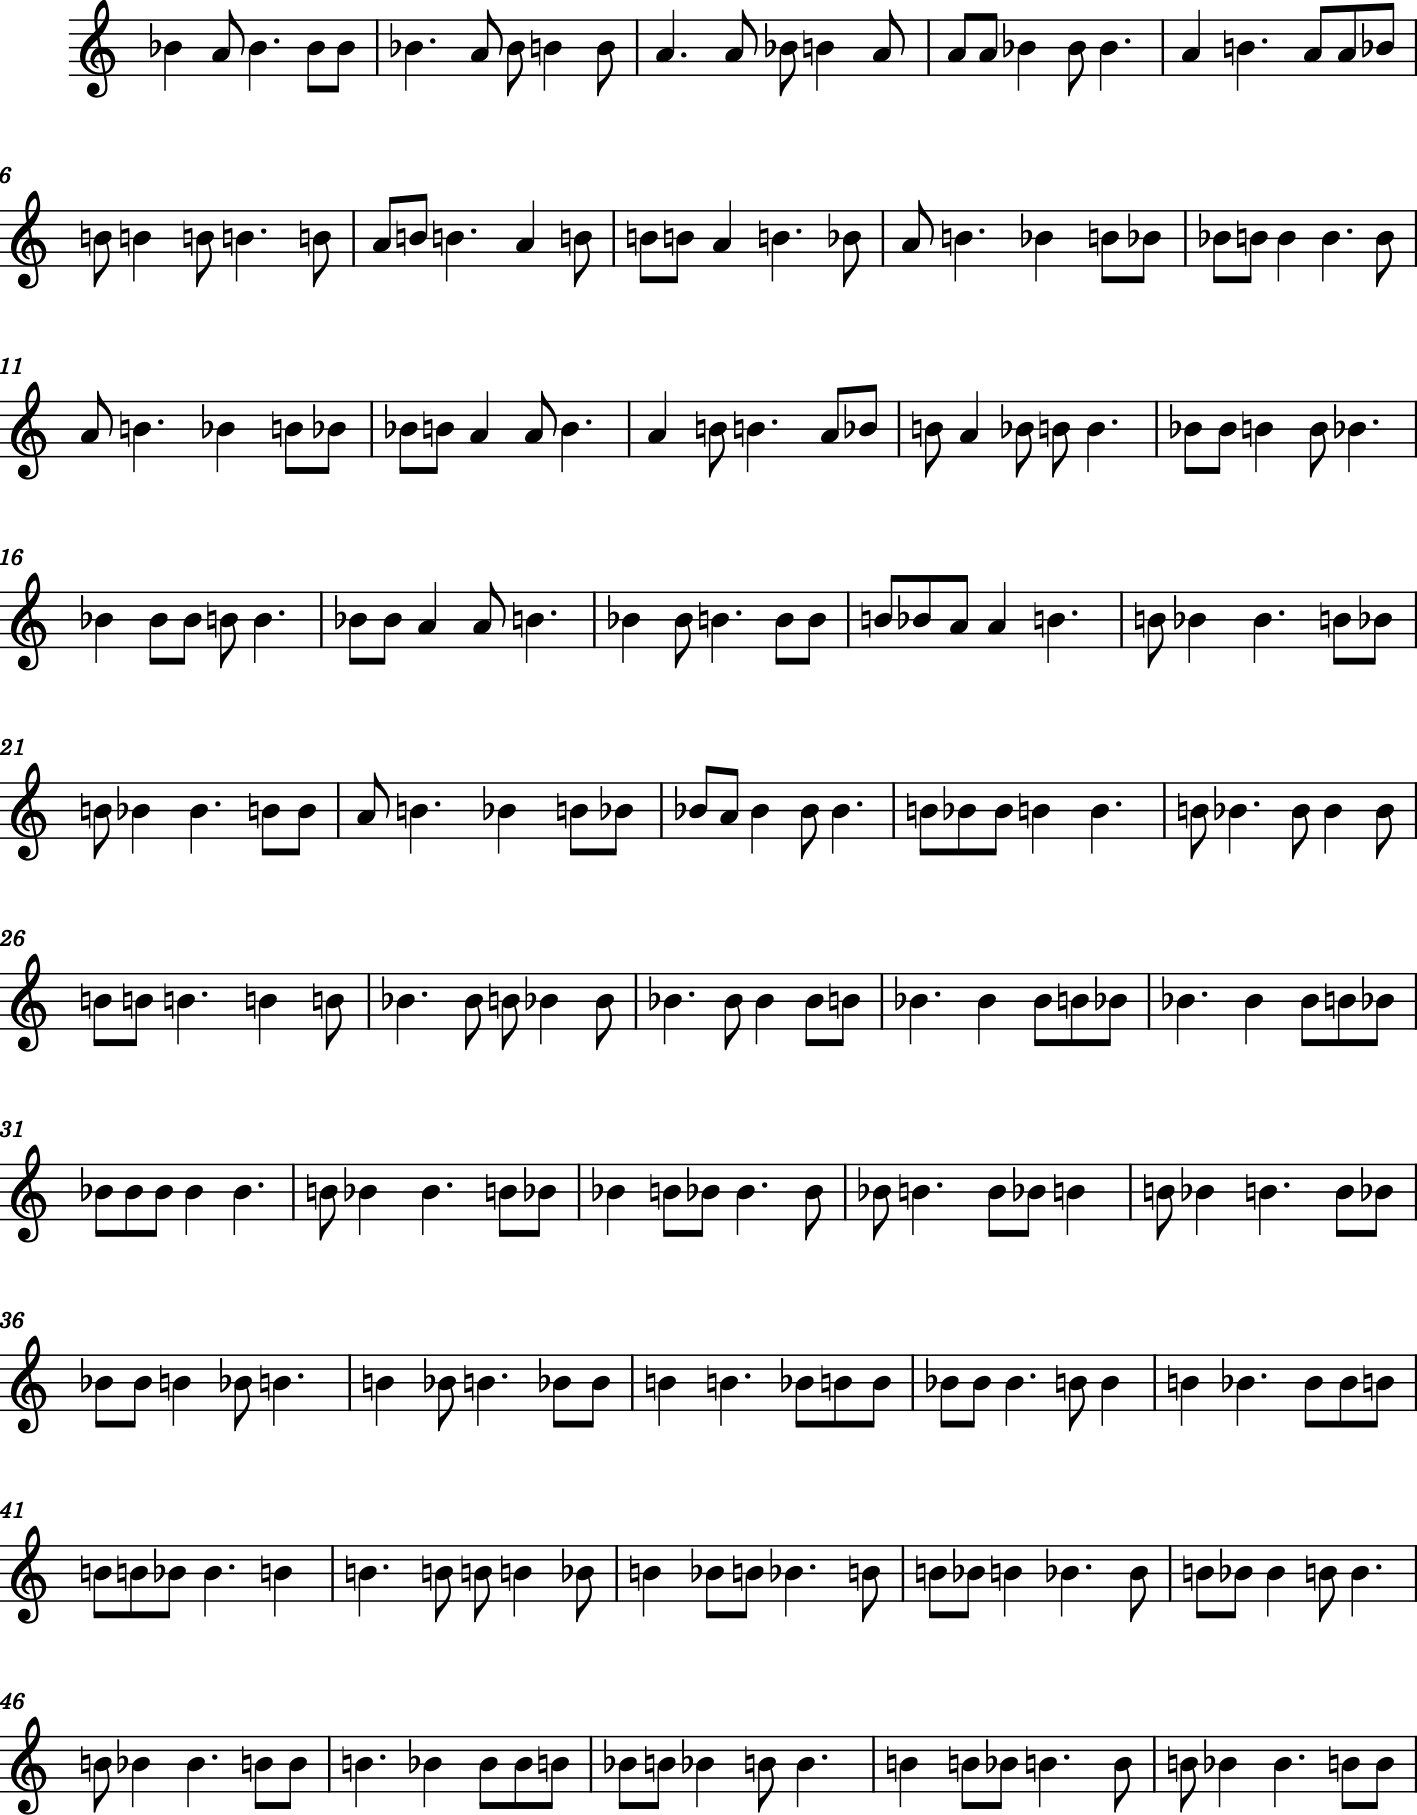

In [56]:
s.show()

In [53]:
overall_duration = float(measure_count*4*Fraction(timeSig)/bpm)
print(f'Before uncommenting the following line to listen to the audio, please note that this rendition lasts {overall_duration} minutes.')

Before uncommenting the following line to listen to the audio, please note that this rendition lasts 1.9090909090909092 minutes.


In [54]:
#play(s)

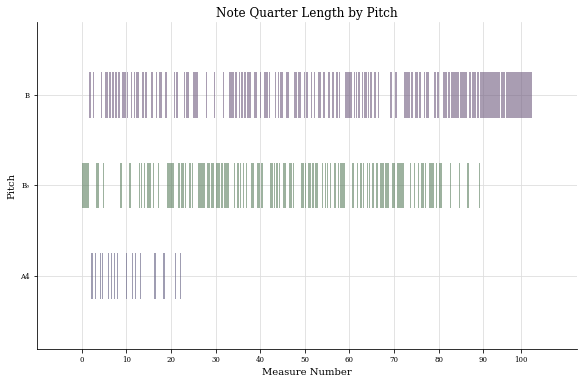

In [55]:
s.plot()

# Exercise: Mozart's Würfelspiel

Implement a reduced version of Mozart's Würfelspiel, using a coin toss instead of a dice roll (i.e., only two options for each bar). 

You find the original score here:

https://ks4.imslp.net/files/imglnks/usimg/b/bc/IMSLP20432-PMLP47543-mozart_-_dice_waltz.pdf